In [37]:
%pylab inline
import torch.nn as nn
import torch
import numpy as np
from tqdm import trange
torch.set_printoptions(sci_mode=False)



%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [38]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  print(fp)
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

/tmp/23278f029ff68f1e993776e500ce06b9
/tmp/d8b415e67abd11881e156b8f111d3300
/tmp/b0cdab8e37ae7c1c5560ee858afaac1d
/tmp/d4fdde61aca9f72d5fe2315410bb46a5


In [39]:
import torch.nn as nn
import torch.nn.functional as F
class BobNet(torch.nn.Module):
    def __init__(self) -> None:
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x


loss 0.43 accuracy 0.95: 100%|██████████| 1000/1000 [00:02<00:00, 389.32it/s]


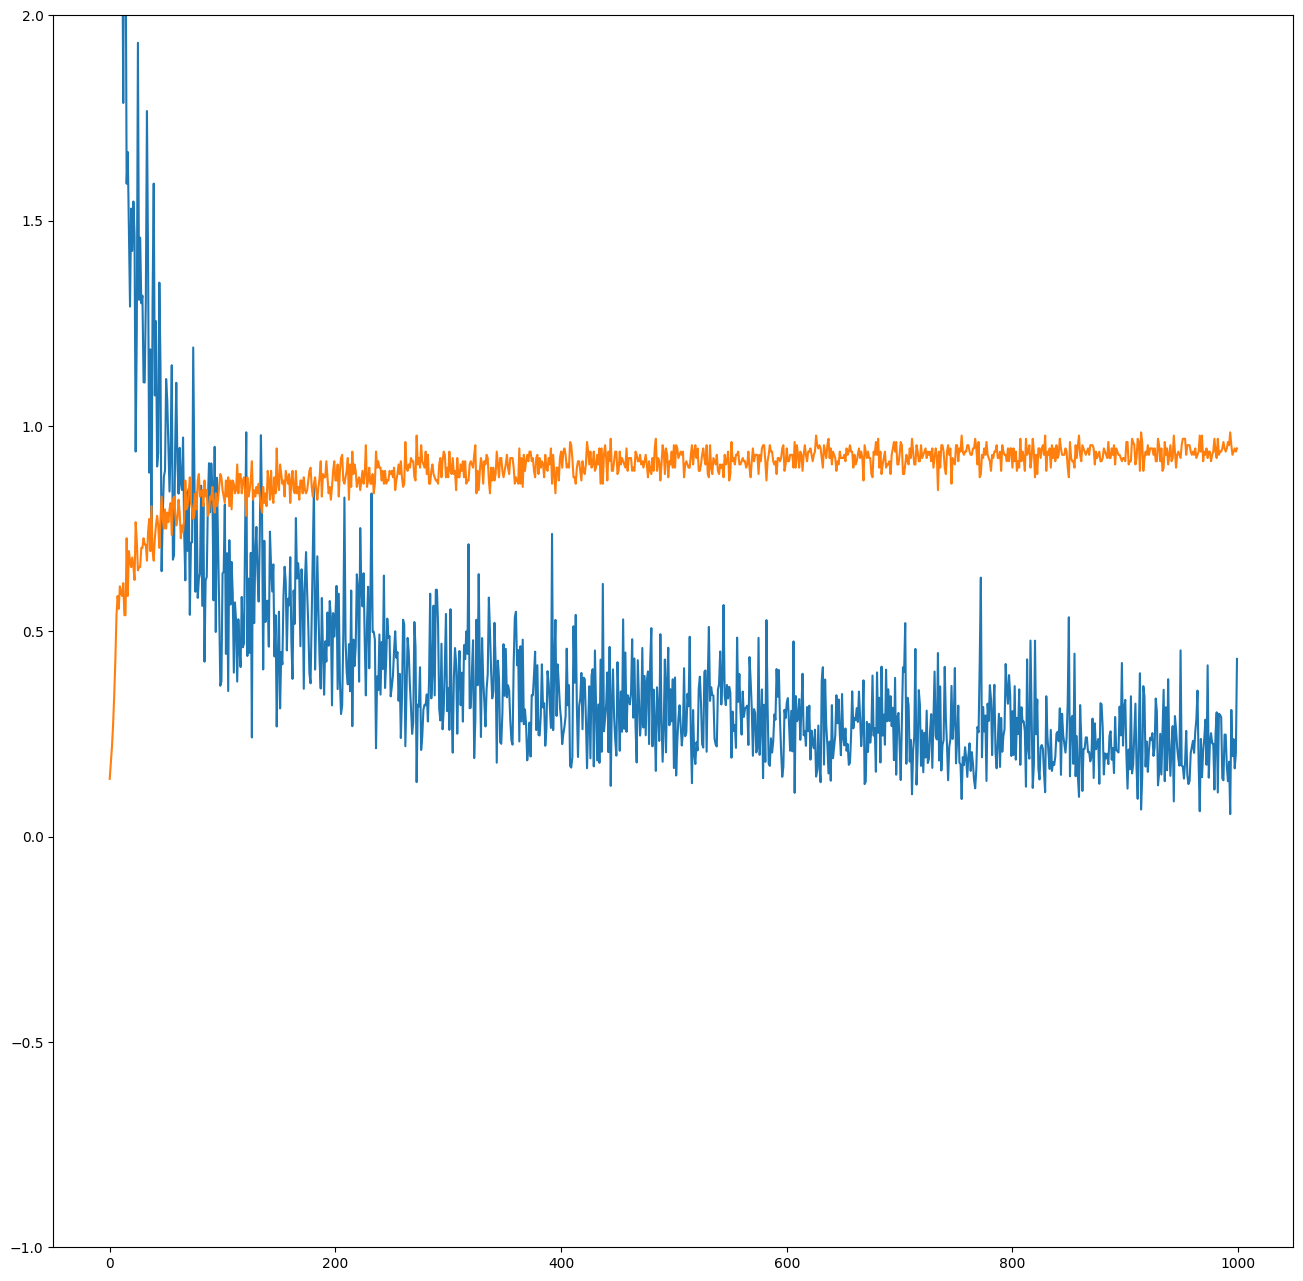

In [40]:
BS = 128

model = BobNet()
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0)
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=BS)
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-1, 2)
plot(losses)
plot(accuracies)

In [41]:
#evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9255

(tensor([1.]), tensor([[ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]))

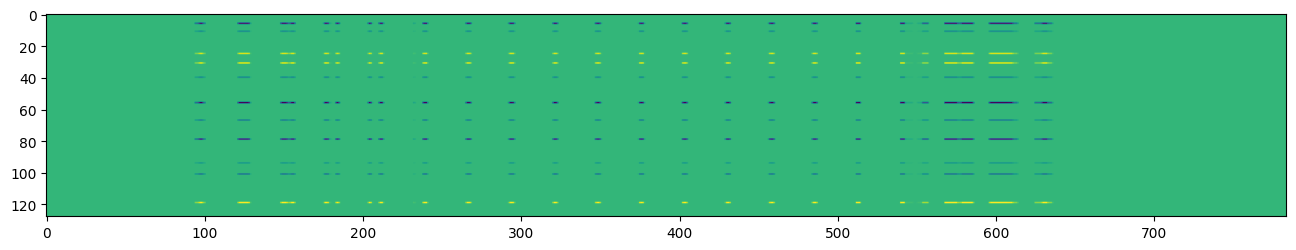

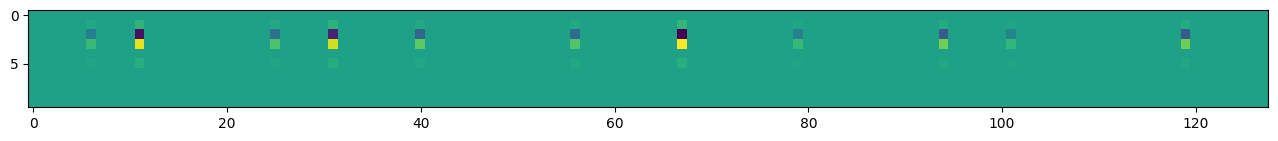

In [42]:
#understand gradients
model.zero_grad()
out = model(torch.tensor(X_test[1:2].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[1:2]).long())
loss.retain_grad()
loss.backward()
figsize(16,16)
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)
loss.grad, out.grad

In [43]:
#init the network

l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)

l1 = model.l1.weight.detach().numpy().transpose()
l2 = model.l2.weight.detach().numpy().transpose()

In [44]:
#numpy forward pass

def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x
Y_test_preds_out = forward(X_test.reshape((-1, 28 * 28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


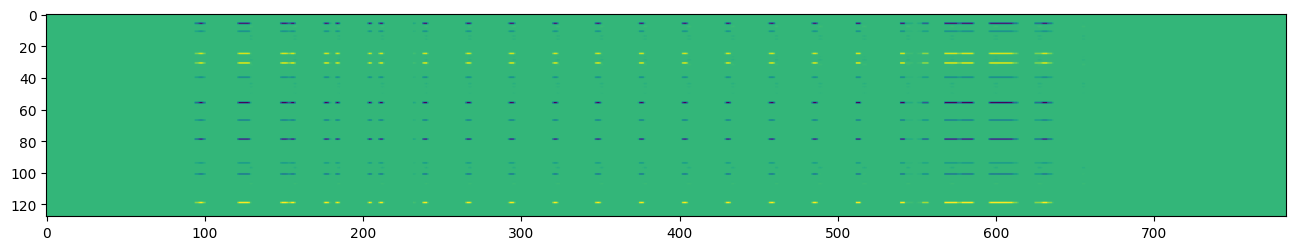

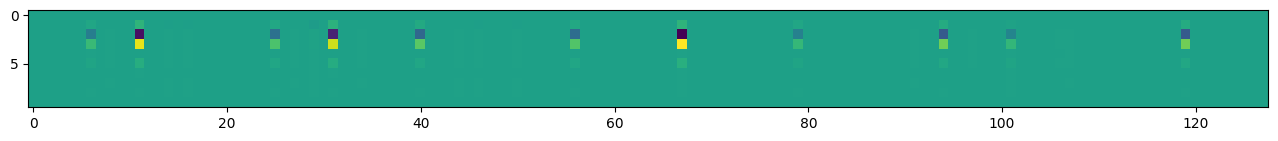

In [55]:

def logsumexp(x):
    c=x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1,1))).sum(axis=1))

#still to be understood
samp = [1,2] 
out = np.zeros((len(samp),10), np.float32)
out[range(out.shape[0]),Y_test[samp]] = 1

print(out)
#forward pass

x = X_test[samp].reshape((-1, 28*28))
x_l1 = x.dot(l1)
x_relu = np.maximum(x_l1, 0)
x_l2 = x_relu.dot(l2)
x_lsm = x_l2 - logsumexp(x_l2).reshape((-1,1))
x_loss =(-out * x_lsm).mean(axis=1)


#backward pass  hard as fuck!!
d_out = -out/len(samp)

dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1,1))

#derivative of l2
d_l2 = x_relu.T.dot(dx_lsm)
dx_relu = dx_lsm.dot(l2.T)

#derivative of relu

dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

#derivative of l1
d_l1 = x.T.dot(dx_l1)

imshow(d_l1.T)
figure()
imshow(d_l2.T)